# Tutorial for Neural Differential Equations (NDEs)
## 1. Medical Data Analysis: Early Detection of Sepsis Using Physiological Data (Physionet Sepsis)

In [ ]:
# ignore version warning
import warnings
warnings.simplefilter("ignore", UserWarning)

In [ ]:
# install the required libraries
!pip install torchsde          # sde-solver
!pip install torchdiffeq       # ode-solver
!pip install torchcde          # cde-solver
!pip install sktime            # time-series tool

In [ ]:
# load git for data preprocessing (Physionet Sepsis)
!git clone https://github.com/yongkyung-oh/Stable-Neural-SDEs.git

In [ ]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchcde
import torchsde
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.metrics import roc_auc_score

def seed_everything(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.random.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
seed_everything(42)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
source_folder = '/content/drive/MyDrive/Tutorial_for_NDEs/processed_data'
destination_folder = '/content/Stable-Neural-SDEs/benchmark_classification/datasets/processed_data'
!ln -s "{source_folder}" "{destination_folder}"

In [ ]:
%cd /content/Stable-Neural-SDEs/benchmark_classification/datasets/processed_data/
import utils
file_path = 'sepsis.csv'
data = pd.read_csv(file_path)
data.head(100)

/content/drive/MyDrive/Tutorial_for_NDEs/processed_data


,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,BaseExcess,HCO3,...,WBC,Fibrinogen,Platelets,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,44.76,1,NaN,NaN,-0.04,1,0
1,113.0,95.0,NaN,NaN,86.0,NaN,25.0,NaN,NaN,NaN,...,NaN,NaN,NaN,44.76,1,NaN,NaN,-0.04,2,0
2,114.0,94.0,36.83,NaN,87.0,NaN,26.0,NaN,NaN,NaN,...,NaN,NaN,NaN,44.76,1,NaN,NaN,-0.04,3,0
3,115.0,94.0,NaN,NaN,86.0,NaN,28.0,NaN,NaN,21.0,...,30.7,243.0,205.0,44.76,1,NaN,NaN,-0.04,4,0
4,117.0,95.0,NaN,NaN,87.0,NaN,22.0,NaN,NaN,21.0,...,30.7,243.0,NaN,44.76,1,NaN,NaN,-0.04,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,89.0,98.0,36.89,102.0,82.0,68.0,20.0,NaN,NaN,NaN,...,NaN,NaN,NaN,75.00,0,1.0,0.0,-213.10,33,1
96,88.0,98.0,NaN,97.0,77.0,64.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,75.00,0,1.0,0.0,-213.10,34,1
97,89.0,100.0,NaN,100.0,81.0,68.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,75.00,0,1.0,0.0,-213.10,35,1
98,88.0,100.0,NaN,98.0,78.0,66.0,20.0,NaN,NaN,NaN,...,NaN,NaN,NaN,75.00,0,1.0,0.0,-213.10,36,1


## Vital Signs (Columns 1-8)

| Column | Description                                         |
|--------|-----------------------------------------------------|
| HR     | Heart rate (beats per minute)                       |
| O2Sat  | Pulse oximetry (%)                                   |
| Temp   | Temperature (°C)                                    |
| SBP    | Systolic BP (mm Hg)                                 |
| MAP    | Mean arterial pressure (mm Hg)                       |
| DBP    | Diastolic BP (mm Hg)                               |
| Resp   | Respiration rate (breaths per minute)              |
| EtCO2  | End tidal carbon dioxide (mm Hg)                    |

## Laboratory Values (Columns 9-34)

| Column             | Description                                         |
|--------------------|-----------------------------------------------------|
| BaseExcess         | Measure of excess bicarbonate (mmol/L)             |
| HCO3               | Bicarbonate (mmol/L)                               |
| FiO2               | Fraction of inspired oxygen (%)                     |
| pH                 | N/A                                               |
| PaCO2              | Partial pressure of carbon dioxide from arterial blood (mm Hg) |
| SaO2               | Oxygen saturation from arterial blood (%)           |
| AST                | Aspartate transaminase (IU/L)                      |
| BUN                | Blood urea nitrogen (mg/dL)                        |
| Alkalinephos      | Alkaline phosphatase (IU/L)                         |
| Calcium            | (mg/dL)                                           |
| Chloride           | (mmol/L)                                         |
| Creatinine         | (mg/dL)                                           |
| Bilirubin_direct    | Bilirubin direct (mg/dL)                         |
| Glucose            | Serum glucose (mg/dL)                             |
| Lactate            | Lactic acid (mg/dL)                               |
| Magnesium          | (mmol/dL)                                        |
| Phosphate          | (mg/dL)                                          |
| Potassium          | (mmol/L)                                        |
| Bilirubin_total    | Total bilirubin (mg/dL)                           |
| TroponinI         | Troponin I (ng/mL)                               |
| Hct                | Hematocrit (%)                                    |
| Hgb                | Hemoglobin (g/dL)                                 |
| PTT                | Partial thromboplastin time (seconds)             |
| WBC                | Leukocyte count (count*10^3/µL)                  |
| Fibrinogen         | (mg/dL)                                          |
| Platelets          | (count*10^3/µL)                                  |

## Demographics (Columns 35-40)

| Column          | Description                                          |
|-----------------|------------------------------------------------------|
| Age             | Years (100 for patients 90 or above)                 |
| Gender          | Female (0) or Male (1)                              |
| Unit1          | Administrative identifier for ICU unit (MICU)       |
| Unit2          | Administrative identifier for ICU unit (SICU)       |
| HospAdmTime     | Hours between hospital admit and ICU admit           |
| ICULOS          | ICU length-of-stay (hours since ICU admit)          |

## Outcome (Column 41)

| Column       | Description                                         |
|--------------|-----------------------------------------------------|
| SepsisLabel  | For sepsis patients, SepsisLabel is 1 if $t \geq t_{\text{sepsis}} - 6$ and 0 if $t < t_{\text{sepsis}} - 6$. For non-sepsis patients, SepsisLabel is 0. |



In [ ]:
sepsis_label_count = data['SepsisLabel'].value_counts()
count_of_ones = sepsis_label_count.get(1, 0)
percentage_of_ones = (count_of_ones / len(data)) * 100
print(f"Positive rate of sepsis = {percentage_of_ones:.2f}%")

Positive rate of sepsis = 2.13%


In [ ]:
# data preprocessing
%cd /content/Stable-Neural-SDEs/benchmark_classification/
import datasets
times, train_loader, val_loader, test_loader = datasets.sepsis.get_data(True, True, 1024) # batch = 1024

In [ ]:
# MLP for modeling the dirft and diffusion networks
class MLP(nn.Module):
    def __init__(self, in_size, out_size, hidden_dim, num_layers):
        super().__init__()

        model = [nn.Linear(in_size, hidden_dim), nn.ReLU()]
        for _ in range(num_layers - 1):
            model.append(nn.Linear(hidden_dim, hidden_dim))
            model.append(nn.ReLU())
        model.append(nn.Linear(hidden_dim, out_size))
        self._model = nn.Sequential(*model)

    def forward(self, x):
        return self._model(x)

In [ ]:
# ODE function
class NeuralODEFunc(nn.Module):
    def __init__(self, hidden_dim, hidden_hidden_dim, num_layers):
        super(NeuralODEFunc, self).__init__()
        self.sde_type = "ito"
        self.noise_type = "diagonal"
        self.linear_in = nn.Linear(hidden_dim + 2, hidden_dim)
        self.f_net = MLP(hidden_dim, hidden_dim, hidden_hidden_dim, num_layers)
        self.linear_out = nn.Linear(hidden_dim, hidden_dim)

    def f(self, t, y):
        if t.dim() == 0:
            t = torch.full_like(y[:, 0], fill_value=t).unsqueeze(-1)
        yy = self.linear_in(torch.cat((torch.sin(t), torch.cos(t), y), dim=-1))
        return self.f_net(yy).tanh()

    def g(self, t, y):
        if t.dim() == 0:
            t = torch.full_like(y[:, 0], fill_value=t).unsqueeze(-1)
        yy = torch.zeros(y.size(0), y.size(1)).to(y.device)
        return yy

In [ ]:
# SDE function
class NeuralSDEFunc(nn.Module):
    def __init__(self, hidden_dim, hidden_hidden_dim, num_layers):
        super(NeuralSDEFunc, self).__init__()
        self.sde_type = "ito"
        self.noise_type = "diagonal"
        self.linear_in = nn.Linear(hidden_dim + 2, hidden_dim)
        self.f_net = MLP(hidden_dim, hidden_dim, hidden_hidden_dim, num_layers)
        self.linear_out = nn.Linear(hidden_dim, hidden_dim)
        self.noise_in = nn.Linear(hidden_dim + 2, hidden_dim)
        self.g_net = MLP(hidden_dim, hidden_dim, hidden_hidden_dim, num_layers)

    def f(self, t, y):
        if t.dim() == 0:
            t = torch.full_like(y[:, 0], fill_value=t).unsqueeze(-1)
        yy = self.linear_in(torch.cat((torch.sin(t), torch.cos(t), y), dim=-1))
        return self.f_net(yy).tanh()

    def g(self, t, y):
        if t.dim() == 0:
            t = torch.full_like(y[:, 0], fill_value=t).unsqueeze(-1)
        yy = self.noise_in(torch.cat((torch.sin(t), torch.cos(t), y), dim=-1))
        return self.g_net(yy).tanh()

In [ ]:
class NDE_model(torch.nn.Module):
    def __init__(self, hidden_dim, output_dim, num_layers, vector_field=None):
        super().__init__()
        self.func = vector_field(hidden_dim, hidden_dim, num_layers)
        self.linear = torch.nn.Sequential(torch.nn.Linear(hidden_dim, hidden_dim),
                                          torch.nn.BatchNorm1d(hidden_dim), torch.nn.ReLU(), torch.nn.Dropout(0.1),
                                          torch.nn.Linear(hidden_dim, output_dim))

    def forward(self, times, coeffs, final_index, z0):
        final_index, t = utils.time(final_index, times)
        z_t = torchsde.sdeint(sde=self.func, y0=z0, ts=t, dt=1, method='euler') # sde solve
        z_t = utils.transform(final_index, z_t)
        # linear mapplng
        pred_y = self.linear(z_t)
        return pred_y

In [ ]:
output_dim = 1
hidden_dim = 32
num_layers = 3
num_epochs = 200
lr = 1e-3

In [ ]:
# MLP for z(0), initial value of z(t)
class InitialValueNetwork(torch.nn.Module):
    def __init__(self, intensity, hidden_dim, model):
        super(InitialValueNetwork, self).__init__()
        self.linear1 = torch.nn.Linear(7, 256)
        self.linear2 = torch.nn.Linear(256, hidden_dim)
        self.model = model

    def forward(self, times, coeffs, final_index):
        *coeffs, static = coeffs
        z0 = self.linear1(static)
        z0 = z0.relu()
        z0 = self.linear2(z0)
        return self.model(times, coeffs, final_index, z0=z0)

In [ ]:
model_name = ['ODE', 'SDE']

func_name = {
    'ODE': NeuralODEFunc,
    'SDE': NeuralSDEFunc,
}

train_loss_list = {name: [] for name in model_name}
test_auroc_list = {name: [] for name in model_name}
best_test_auroc = {name: 0 for name in model_name}
best_epoch = {name: 0 for name in model_name}

for nnn in model_name:
    model = NDE_model(hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers, vector_field=func_name[nnn])
    model = InitialValueNetwork(True, hidden_dim, model).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=lr * 0.01)
    criterion = torch.nn.CrossEntropyLoss()

    for epoch in range(1, num_epochs + 1):
        model.train()
        total_loss = 0
        all_preds = []
        all_trues = []

        for batch in train_loader:
            batch = tuple(b.to(device) for b in batch)
            *coeffs, true, lengths = batch
            pred = model(times.to(device), coeffs, lengths).squeeze(-1)
            loss = criterion(pred, true)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            all_preds.append(pred.cpu().detach().numpy())
            all_trues.append(true.cpu().detach().numpy())

        avg_train_loss = total_loss / len(train_loader)
        train_loss_list[nnn].append(avg_train_loss)
        all_preds = np.concatenate(all_preds)
        all_trues = np.concatenate(all_trues)
        train_auroc = roc_auc_score(all_trues, all_preds)

        model.eval()
        total_loss = 0
        all_preds = []
        all_trues = []

        with torch.no_grad():
            for batch in test_loader:
                batch = tuple(b.to(device) for b in batch)
                *coeffs, true, lengths = batch
                pred = model(times.to(device), coeffs, lengths).squeeze(-1)
                loss = criterion(pred, true)
                total_loss += loss.item()
                all_preds.append(pred.cpu())
                all_trues.append(true.cpu())

        avg_test_loss = total_loss / len(test_loader)
        all_preds = torch.cat(all_preds, dim=0)
        all_trues = torch.cat(all_trues, dim=0)
        test_auroc = roc_auc_score(all_trues.numpy(), all_preds.numpy())
        test_auroc_list[nnn].append(test_auroc)

        # Update best AUROC
        if test_auroc > best_test_auroc[nnn]:
            best_test_auroc[nnn] = test_auroc
            best_epoch[nnn] = epoch

        if epoch % 20 == 0 or epoch == num_epochs:
            print(f"Model: {nnn} | Epoch: {epoch}/{num_epochs} | Train Loss: {avg_train_loss:.4f} | Train AUROC: {train_auroc:.4f} | Test Loss: {avg_test_loss:.4f} | Test AUROC: {test_auroc:.4f}")

    print(f"Best Test AUROC for Neural {nnn}: {best_test_auroc[nnn]:.4f} at Epoch {best_epoch[nnn]} \n")

Model: ODE | Epoch: 20/200 | Train Loss: 355.1671 | Train AUROC: 0.7793 | Test Loss: 346.6281 | Test AUROC: 0.7784
Model: ODE | Epoch: 40/200 | Train Loss: 348.6175 | Train AUROC: 0.7904 | Test Loss: 359.4823 | Test AUROC: 0.7639
Model: ODE | Epoch: 60/200 | Train Loss: 343.7609 | Train AUROC: 0.7978 | Test Loss: 343.3802 | Test AUROC: 0.7892
Model: ODE | Epoch: 80/200 | Train Loss: 345.5407 | Train AUROC: 0.8008 | Test Loss: 361.0761 | Test AUROC: 0.7765
Model: ODE | Epoch: 100/200 | Train Loss: 343.6352 | Train AUROC: 0.8079 | Test Loss: 358.2490 | Test AUROC: 0.7804
Model: ODE | Epoch: 120/200 | Train Loss: 342.9854 | Train AUROC: 0.8134 | Test Loss: 349.8318 | Test AUROC: 0.7910
Model: ODE | Epoch: 140/200 | Train Loss: 346.3183 | Train AUROC: 0.8131 | Test Loss: 359.5426 | Test AUROC: 0.7828
Model: ODE | Epoch: 160/200 | Train Loss: 339.1647 | Train AUROC: 0.8212 | Test Loss: 351.5216 | Test AUROC: 0.7821
Model: ODE | Epoch: 180/200 | Train Loss: 344.8768 | Train AUROC: 0.8132 | T

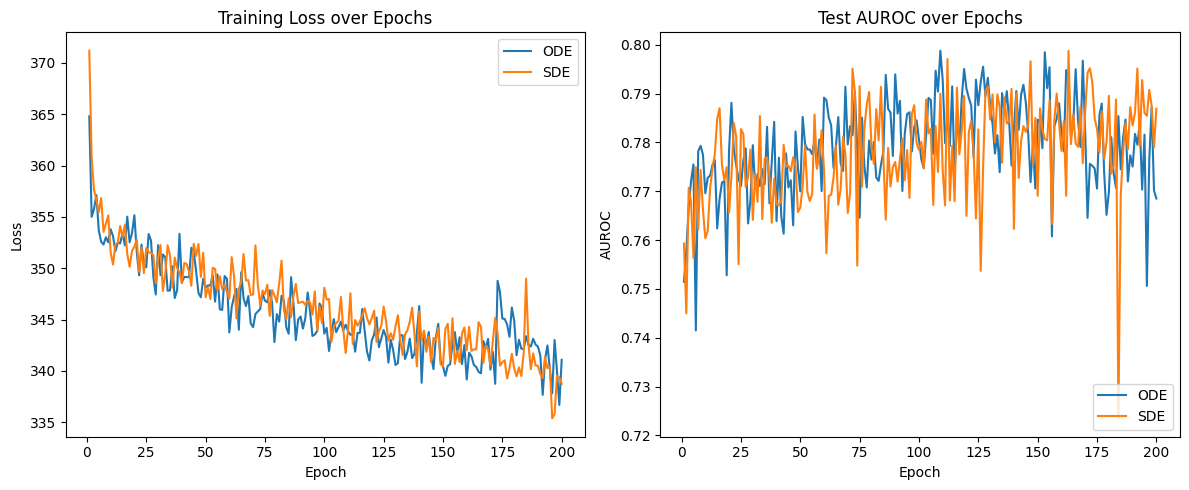

In [ ]:
# Plot training loss and test AUROC
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_loss_list['ODE'], label='ODE')
plt.plot(range(1, num_epochs + 1), train_loss_list['SDE'], label='SDE')
plt.title('Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), test_auroc_list['ODE'], label='ODE')
plt.plot(range(1, num_epochs + 1), test_auroc_list['SDE'], label='SDE')
plt.title('Test AUROC over Epochs')
plt.xlabel('Epoch')
plt.ylabel('AUROC')
plt.legend(loc='lower right')

plt.tight_layout()
plt.show()

 ## 2. Economic Data Analysis: GDP Nowcasting (KOR GDP)

In [ ]:
%cd /content/Stable-Neural-SDEs/benchmark_classification/datasets/processed_data/
file_path = 'GDP_KOR_quarterly.csv'
data = pd.read_csv(file_path)
data['Date'] = pd.to_datetime(data['Date'])
data

/content/drive/MyDrive/Tutorial_for_NDEs/processed_data


,num,Date,GDP,Export Amount,Industry,Stock Market Capitalization,Balance of Financial Account in International Balance of Payments,Balance of Current Account in International Balance of Payments,Credit Side of Current Account in International Balance of Payments,Debit Side of Current Account in International Balance of Payments,...,Balance of International Balance of Payments,Assets of International Investment Position,Liabilities of International Investment Position,Net Position of International Investment,Import Amount,Nominal Effective Exchange Rate,Retail Sales,Consumer Price Index,Unemployment Rate,Central Bank Policy Rate
0,0,2001-03-31,5.03,2.400000,3.850574,-35.687808,762.863436,213.862870,-0.543428,-1.703316,...,59.954543,3.083624,-19.643449,59.332781,-1.433333,-6.595613,6.774516,3.693333,4.600000,5.083333
1,1,2001-06-30,4.99,-11.566667,3.563033,-25.406024,2.368281,-36.870266,-9.339919,-7.920890,...,49.958205,-0.161816,-18.364988,52.027732,-13.366667,-8.765157,9.958711,5.040000,3.933333,5.000000
2,2,2001-09-30,3.49,-19.766667,3.082639,-29.710194,-48.130663,-99.581806,-16.077770,-9.729426,...,52.187489,-0.327045,-15.691802,56.326907,-15.433333,-9.332782,10.510678,4.250000,3.733333,4.416667
3,3,2001-12-31,5.41,-19.566667,6.577770,12.991995,-66.167786,-95.670918,-18.774521,-12.960677,...,-58.300690,-2.091121,5.223826,-36.525817,-17.066667,-6.234768,13.294188,3.293333,3.666667,4.000000
4,4,2002-03-31,7.27,-11.233333,9.161088,32.879502,-100.478501,-1.283317,-7.905566,-7.947275,...,-119.115591,2.595723,20.988827,-102.409068,-11.366667,0.992175,15.167611,2.526667,3.500000,4.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82,82,2021-09-30,4.56,27.066667,5.297080,45.337206,-12.652553,-3.628426,27.886816,33.419800,...,14.336173,18.136079,19.840076,14.333569,37.766667,-0.168096,7.916667,2.536667,3.166667,0.666667
83,83,2021-12-31,4.58,24.800000,6.219205,15.553149,-49.431885,-38.169591,23.545998,37.297188,...,40.652174,12.336708,3.099007,40.652178,39.433333,-4.903992,10.510000,3.546667,3.400000,0.916667
84,84,2022-03-31,3.49,18.466667,5.987845,-1.623403,-33.735646,-26.383537,20.510660,25.873462,...,44.011121,11.276364,0.319129,44.010356,30.233333,-5.199823,7.080000,3.910000,3.000000,1.250000
85,85,2022-06-30,2.93,13.200000,6.162303,-20.379379,-48.744668,-51.797700,10.579911,17.754440,...,49.422522,3.171450,-12.063978,49.420030,23.133333,-5.528493,6.806667,5.380000,2.800000,1.666667


In [ ]:
# Split the data: 80% for training, 20% for testing
train_size = int(len(data) * 0.8)
train_data = data[:train_size]
test_data = data[train_size:]

# Separate features and target
times_train = train_data['num'].values
y_train = train_data['GDP'].values
X_train = train_data.drop(columns=['Date', 'GDP', 'num']).values
times_test = test_data['num'].values
y_test = test_data['GDP'].values
X_test = test_data.drop(columns=['Date', 'GDP', 'num']).values

# Min-Max normalization function
def min_max_normalize(X, min_val, max_val):
    return (X - min_val) / (max_val - min_val)

# Normalize the data
min_X = X_train.min(axis=0)
max_X = X_train.max(axis=0)
X_train_normalized = min_max_normalize(X_train, min_X, max_X)
X_test_normalized = min_max_normalize(X_test, min_X, max_X)
min_y = y_train.min(axis=0)
max_y = y_train.max(axis=0)
y_train_normalized = min_max_normalize(y_train, min_y, max_y)
y_test_normalized = min_max_normalize(y_test, min_y, max_y)

# Convert to PyTorch tensors
times_train_tensor = torch.tensor(times_train, dtype=torch.float32)
X_train_tensor = torch.tensor(X_train_normalized, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_normalized, dtype=torch.float32)
times_test_tensor = torch.tensor(times_test, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_normalized, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_normalized, dtype=torch.float32)

# Create TensorDataset
train_dataset = TensorDataset(times_train_tensor, X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(times_test_tensor, X_test_tensor, y_test_tensor)

# Create DataLoader
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [ ]:
input_dim = 20
output_dim = 1
hidden_dim = 128
num_layers = 1
num_epochs = 200
lr = 5e-4

In [ ]:
# MLP for z(0), initial value of z(t)
class InitialValueNetwork(torch.nn.Module):
    def __init__(self, hidden_channels, model):
        super(InitialValueNetwork, self).__init__()
        self.linear1 = torch.nn.Linear(input_dim, 256)
        self.linear2 = torch.nn.Linear(256, hidden_channels)
        self.model = model

    def forward(self, times, coeffs):
        z0 = self.linear1(coeffs)
        z0 = z0.relu()
        z0 = self.linear2(z0)
        return self.model(times, coeffs, z0=z0)

In [ ]:
class NDE_model(torch.nn.Module):
    def __init__(self, hidden_dim, output_dim, num_layers, vector_field=None):
        super().__init__()
        self.func = vector_field(hidden_dim, hidden_dim, num_layers)
        self.linear = torch.nn.Sequential(torch.nn.Linear(hidden_dim, hidden_dim),
                                          torch.nn.BatchNorm1d(hidden_dim), torch.nn.ReLU(), torch.nn.Dropout(0.3),
                                          torch.nn.Linear(hidden_dim, output_dim))

    def forward(self, times, coeffs, z0=None):
        z_t = torchsde.sdeint(sde=self.func, y0=z0, ts=times, dt=1, method='euler') # sde solve

        # z_t is a tensor of shape (times, ..., channels), so change this to (..., times, channels)
        for i in range(len(z_t.shape) - 2, 0, -1):
            z_t = z_t.transpose(0, i)

        # Linear mapping
        pred_y = self.linear(z_t[-1, :, :])
        return pred_y

In [ ]:
model_name = ['ODE', 'SDE']

func_name = {
    'ODE': NeuralODEFunc,
    'SDE': NeuralSDEFunc,
}

train_loss_list = {name: [] for name in model_name}
test_loss_list = {name: [] for name in model_name}
best_test_loss = {name: float('inf') for name in model_name}
best_epoch = {name: 0 for name in model_name}
best_preds = {name: None for name in model_name}

for nnn in model_name:
    model = NDE_model(hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers, vector_field=func_name[nnn])
    model = InitialValueNetwork(hidden_dim, model).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=lr * 0.01)
    criterion = torch.nn.MSELoss()

    for epoch in range(1, num_epochs + 1):
        model.train()
        total_loss = 0
        all_preds = []
        all_trues = []

        for batch in train_loader:
            batch = tuple(b.to(device) for b in batch)
            times, coeffs, true = batch
            pred = model(times.to(device), coeffs).squeeze()
            loss = criterion(pred, true)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            all_preds.append(pred.cpu().detach().numpy())
            all_trues.append(true.cpu().detach().numpy())

        avg_train_loss = total_loss / len(train_loader)
        train_loss_list[nnn].append(avg_train_loss)
        all_preds = np.concatenate(all_preds)
        all_trues = np.concatenate(all_trues)

        model.eval()
        total_loss = 0
        all_preds_test = []
        all_trues_test = []

        with torch.no_grad():
            for batch in test_loader:
                batch = tuple(b.to(device) for b in batch)
                times, coeffs, true = batch
                pred = model(times.to(device), coeffs).squeeze()
                loss = criterion(pred, true)
                total_loss += loss.item()
                all_preds_test.append(pred.cpu())
                all_trues_test.append(true.cpu())

        avg_test_loss = total_loss / len(test_loader)
        all_preds_test = torch.cat(all_preds_test, dim=0)
        all_trues_test = torch.cat(all_trues_test, dim=0)
        test_loss_list[nnn].append(avg_test_loss)

        # Update best MSE
        if avg_test_loss < best_test_loss[nnn]:
            best_test_loss[nnn] = avg_test_loss
            best_epoch[nnn] = epoch
            best_preds[nnn] = all_preds_test

        if epoch % 20 == 0 or epoch == num_epochs:
            print(f"Model: {nnn} | Epoch: {epoch}/{num_epochs} | Train Loss: {avg_train_loss:.4f} | Test Loss: {avg_test_loss:.4f}")

    print(f"Best Test MSE for Neural {nnn}: {best_test_loss[nnn]:.4f} at Epoch {best_epoch[nnn]} \n")


Model: ODE | Epoch: 20/200 | Train Loss: 0.0884 | Test Loss: 0.1041
Model: ODE | Epoch: 40/200 | Train Loss: 0.0622 | Test Loss: 0.0556
Model: ODE | Epoch: 60/200 | Train Loss: 0.0669 | Test Loss: 0.0378
Model: ODE | Epoch: 80/200 | Train Loss: 0.0665 | Test Loss: 0.0406
Model: ODE | Epoch: 100/200 | Train Loss: 0.0388 | Test Loss: 0.0451
Model: ODE | Epoch: 120/200 | Train Loss: 0.0384 | Test Loss: 0.0365
Model: ODE | Epoch: 140/200 | Train Loss: 0.0337 | Test Loss: 0.0292
Model: ODE | Epoch: 160/200 | Train Loss: 0.0271 | Test Loss: 0.0482
Model: ODE | Epoch: 180/200 | Train Loss: 0.0184 | Test Loss: 0.0621
Model: ODE | Epoch: 200/200 | Train Loss: 0.0183 | Test Loss: 0.0737
Best Test MSE for Neural ODE: 0.0208 at Epoch 6 

Model: SDE | Epoch: 20/200 | Train Loss: 0.0737 | Test Loss: 0.0606
Model: SDE | Epoch: 40/200 | Train Loss: 0.0939 | Test Loss: 0.0573
Model: SDE | Epoch: 60/200 | Train Loss: 0.0752 | Test Loss: 0.0462
Model: SDE | Epoch: 80/200 | Train Loss: 0.0614 | Test Loss:

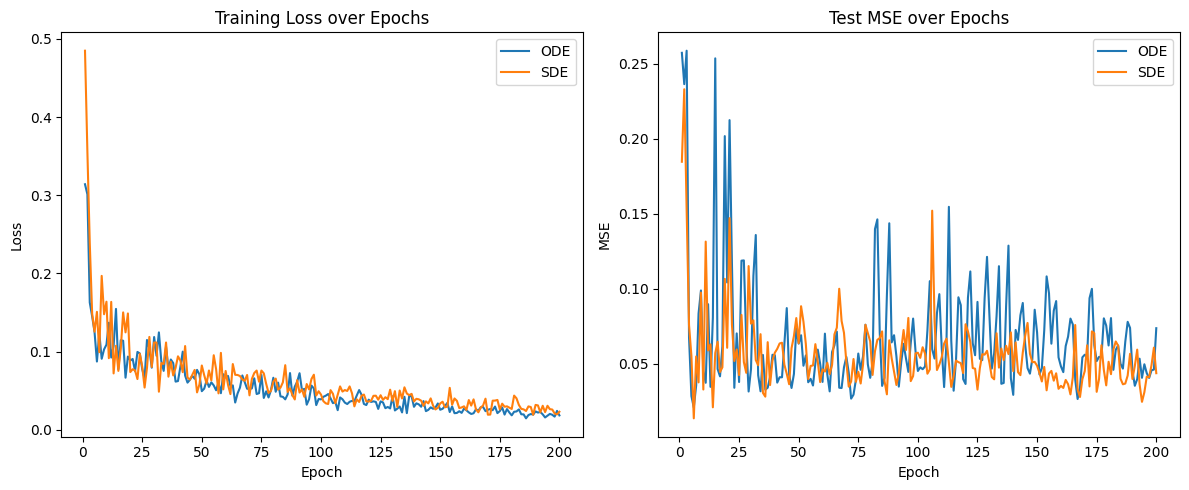

In [ ]:
# Plot training loss and test MSE
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_loss_list['ODE'], label='ODE')
plt.plot(range(1, num_epochs + 1), train_loss_list['SDE'], label='SDE')
plt.title('Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), test_loss_list['ODE'], label='ODE')
plt.plot(range(1, num_epochs + 1), test_loss_list['SDE'], label='SDE')
plt.title('Test MSE over Epochs')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

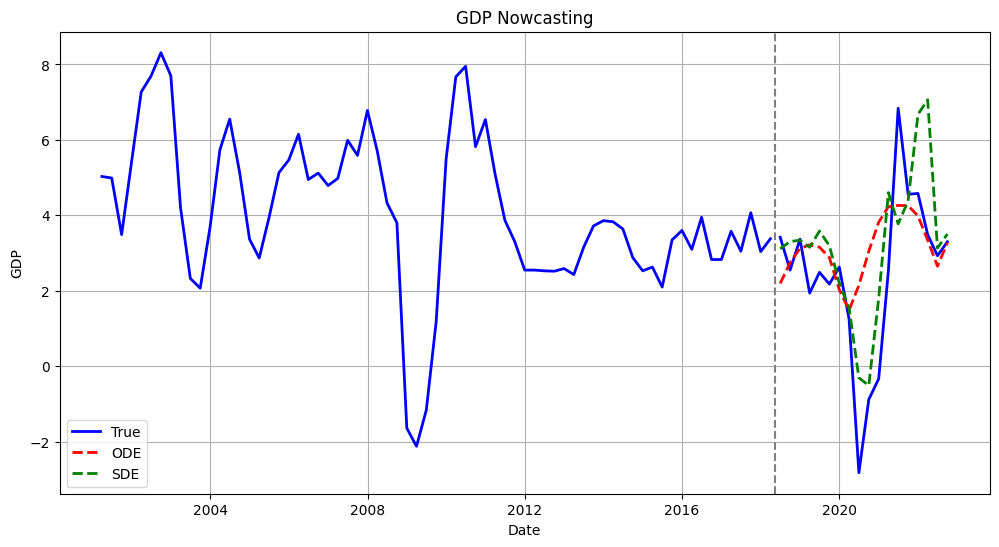

In [ ]:
date = data['Date'].values
best_preds_ode = best_preds['ODE'].numpy() * (max_y - min_y) + min_y
best_preds_sde = best_preds['SDE'].numpy() * (max_y - min_y) + min_y

# Plot Extrapolated GDP
plt.figure(figsize=(12, 6))
plt.plot(date[:len(y_train)], y_train, label='True', color='blue', linestyle='-', linewidth=2)
plt.plot(date[len(y_train):len(y_train) + len(y_test)], y_test, color='blue', linewidth=2)
plt.plot(date[len(y_train):len(y_train) + len(best_preds_ode)], best_preds_ode, label='ODE', color='red', linestyle='--', linewidth=2)
plt.plot(date[len(y_train):len(y_train) + len(best_preds_sde)], best_preds_sde, label='SDE', color='green', linestyle='--', linewidth=2)
midpoint = pd.Timestamp((date[68] + (date[69] - date[68]) / 2))
plt.axvline(x=midpoint, color='gray', linestyle='--', linewidth=1.5)
plt.title('GDP Nowcasting')
plt.xlabel('Date')
plt.ylabel('GDP')
plt.legend()
plt.grid()
plt.show()

## References

[1] Oh, Y., Lim, D., & Kim, S. (2024). Stable Neural Stochastic Differential Equations in Analyzing Irregular Time Series Data. In The Twelfth International Conference on Learning Representations.

[2] Xie, H., Xu, X., Yan, F., Qian, X., & Yang, Y. (2024). Deep Learning for Multi-Country GDP Prediction: A Study of Model Performance and Data Impact (No. 2409.02551).